In [269]:
#####################
# Helper functions - general
#####################
import re
def extract_file_number(f):
    # assuming xxx_Pos<number>.yyy
    f2 = f.split('Pos')[1].split('.')[0]
    s = re.findall("\d+$",f2)
    return (int(s[0]) if s else -1,f)

def get_comp_data(data,point,rad_size):
    return np.average(data[:,point[0]-rad_size:point[0]+rad_size,point[1]-rad_size:point[1]+rad_size],axis=(1,2))

def get_images(path):
    from os import listdir
    from os.path import isfile, join
    file_list= [f for f in listdir(path) if (isfile(join(path, f)) and 'Pos' in f)]
    if len(file_list)<1:
        print('ERROR: No files found in %s'%path)
    else:
        print('Found %d images'%len(file_list))
    return sorted( file_list,key=extract_file_number)

import json
import exifread
import numpy as np
import tifffile as tiff
def get_microscope_stage_pos(path,scale=0.912,deg = 0):
    with open(path, 'rb') as f:
        tags= exifread.process_file(f)  
        d = json.loads(tags['Image Tag 0xC7B3'].values)
    pos = np.array([d['YPositionUm'],-d['XPositionUm']])
    # rotate
    theta = np.radians(deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.matrix([[c, -s], [s, c]])
    pos = np.dot(R,pos.T).T
    pos = np.squeeze(np.asarray(np.round(pos*scale))) #+np.multiply(I_shape,0.5)
    return pos

def get_circ_centers(file_path,flipx = False,flipy=True,sorted=False):
    ''' return compartment center got from csv file via AutoCad dataextraction function.'''
    with open(file_path,'r') as f:
        lines = f.readlines()
        points = np.zeros((len(lines)-1,2))
        radius = np.zeros((len(lines)-1,1))
        for i,line in enumerate(lines[1:]):
            l = line.split(',')
            points[i] = np.array([float(l[1]),float(l[0])])
            radius[i] = float(l[2])
            if (flipy):
                points[i,0] = -points[i,0]
            if (flipx):
                points[i,1] = -points[i,1]
    if sorted:
        ind = np.lexsort((points[:,0], points[:,1] ))
        points = points[ind]
    print ('extracted %d comprtments from csv file'%(len(points)))
    return points,radius

def get_tl_br_comp(comp_list):
    ''' return index of top left, bottom right compartment in a list
    '''
    comp_diag_vec = np.array( [pos[0]+pos[1] for pos in comp_list])
    return [np.argmin(comp_diag_vec),np.argmax(comp_diag_vec)]
       

def affine_unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def affine_angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::"""
    v1_u = affine_unit_vector(v1)
    v2_u = affine_unit_vector(v2)
    r =  np.math.atan2(np.linalg.det([v1_u,v2_u]),np.dot(v1_u,v2_u))
    cosr = np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)
    sinr = np.linalg.det([v1_u,v2_u])
    return r, cosr ,sinr

def affine_get_transform(src,tgt):
    tt = -np.mean(src,axis = 0)
    t  = np.mean(tgt,axis = 0)
    s = np.linalg.norm(tgt[1]-tgt[0])/np.linalg.norm(src[1]-src[0])
    r, cosr ,sinr = affine_angle_between(src[0]-src[1],tgt[0]-tgt[1])
    print('-------transform -------------------')
    print ('scale: %.6f, rotation: %.4f[deg]'%(s,180*r/np.pi))
    print ('src translations: ' + format(tt))
    print ('tgt translations: ' + format(t))
    print('------------------------------------')
    A2 = np.matrix([[s*cosr,-s*sinr,s*(tt[0]*cosr-tt[1]*sinr)+t[0]],
                    [s*sinr, s*cosr,s*(tt[0]*sinr+tt[1]*cosr)+t[1]],
                    [0     ,0      ,1                             ]])
    return s,lambda x: np.asarray((A2*np.vstack((np.matrix(x).reshape(2,1),1)))[0:2,:]).flatten()


class Markers:
    ''' alignment between microscope images and autocad desgin.
        option 1: align by compatment: define reference image and location in pixel for the compatments on the image
            Example: 
            markers = Markers(m1_img_num=0 ,m1_col= 201 ,m1_row = 320 ,m2_img_num=7 ,m2_col=451 ,m2_row=1064 ,m1_comp_num= 3,m2_comp_num=145)
        option 2: align by known locations: define reference image and location in pixel for the compatments, as well as autocad location.
            Example: 
            markers = Markers(m1_img_num=0 ,m1_col= 201 ,m1_row = 320 ,m2_img_num=7 ,m2_col=451 ,m2_row=1064 , m2_design_loc =[-10.34,2.1],m2_design_loc=[7.6,2.1])
    '''
    def __init__(self,m1_img_num,m1_col,m1_row,m2_img_num,m2_col,m2_row,m1_comp_num=None,m2_comp_num=None,m1_design_loc = None,m2_design_loc=None):
        self.m1_img_pos = np.array([m1_row,m1_col])
        self.m2_img_pos = np.array([m2_row,m2_col])
        self.m1_img_num = m1_img_num
        self.m2_img_num = m2_img_num
        self.align_by_compartment=False
        if m1_comp_num and m2_comp_num:
            self.m1_comp_num = m1_comp_num
            self.m2_comp_num = m2_comp_num
            self.align_by_compartment=True
        elif m1_design_loc and m2_design_loc:
            self.m1_design_loc = np.roll(np.array(m1_design_loc),1) # [y,x]
            self.m2_design_loc = np.roll(np.array(m2_design_loc),1) # [y,x]
        else:
            print('[Markers] ERROR - please input m1_comp_num, m2_comp_num or m1_design_loc,m2_design_loc.')

In [268]:
a = np.arange(100,0,-1).reshape(50,2,)
print (a[0])
ind = np.lexsort((a[:,0], a[:,1] ))
a = a[ind]
print (a[0])

[100  99]
[2 1]


In [308]:
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt
import time

class DataGrabber:
    ''' get all compartments data from an experiment using a compartment position file
    It is mandatory for the preview image stage position and zoom will be the same as the data.
    '''
    def __init__(self,preview_path,data_path,out_path,design_csv_path,stage_deg=0.,flipx=False,flipy=True,markers=None):
        self.preview_path = preview_path
        self.data_path = data_path
        self.out_path = out_path
        self.preview_img_list = get_images(self.preview_path)
        self.data_img_list =  get_images(self.data_path)
        self.img_stage_pos = [get_microscope_stage_pos(preview_path+x,deg=stage_deg) for x in self.preview_img_list]
        self.comp_loc_autocad,self.comp_radius_autocad = get_circ_centers(design_csv_path,flipx=flipx,flipy=flipy,sorted=True)       
        self.resolution = np.array([1080,1280])
        self.flipx = flipx ; self.flipy = flipy
        # create output folder:
        import pathlib
        pathlib.Path(out_path).mkdir(parents=True, exist_ok=True) 
        if markers:
            self.set_design_markers(markers)
        
    def set_design_markers(self,markers):
        '''
        shows on which compartments user needs to align.
        user can enter compartment numbers manually by: .show_alignment_comp([<compartment number 1>,<compartment number 2>])
        '''
        self.markers = markers
        if self.markers.align_by_compartment:
            m1_pos = self.comp_loc_autocad[self.markers.m1_comp_num]
            m2_pos = self.comp_loc_autocad[self.markers.m2_comp_num] 
        else:
            m1_pos = self.markers.m1_design_loc
            m2_pos = self.markers.m2_design_loc
            if self.flipx:
                m1_pos[1] = -m1_pos[1] ;  m2_pos[1] = -m2_pos[1]
            if self.flipy:
                m1_pos[0]= -m1_pos[0];  m2_pos[0] = -m2_pos[0]
        # for alignment usage
        self.design_markers = np.empty((2,2))
        self.design_markers[0] = np.array([m1_pos[0],m1_pos[1]])
        self.design_markers[1] = np.array([m2_pos[0],m2_pos[1]])
        
    def show_comp_map(self):
        ''' show map of the design compatments and annotates the markers
        '''
        import matplotlib.pyplot as plt
        f,ax=plt.subplots(1,1,figsize=(15,5))
        y = [x[0] for x in self.comp_loc_autocad]
        x = [x[1] for x in self.comp_loc_autocad]
        ax.scatter(x,y)
        ax.annotate('Marker 1', (m1_pos[1], m1_pos[0]))
        ax.annotate('Marker 2', (m2_pos[1], m2_pos[0]))
        ax.scatter([m1_pos[1],m2_pos[1]],[m1_pos[0],m2_pos[0]])
        print('[DataGrabber] [info] Desgin markers set.')
    
    def compute_alignment(self):
        '''
        matches design file to microscope image set. assign compartments data to be exteacted from the closest image file
        '''
        img_markers = np.empty((2,2))
#         print(microscope_markers.m1_img_pos)
#         print(self.img_stage_pos[microscope_markers.m1_img_num])
        img_markers[0] = self.markers.m1_img_pos + self.img_stage_pos[self.markers.m1_img_num]
        img_markers[1] = self.markers.m2_img_pos + self.img_stage_pos[self.markers.m2_img_num]      
        self.transform_scale, self.transFn = affine_get_transform(self.design_markers,img_markers)
        self.proximity_mat = np.zeros((len(self.preview_img_list),(self.comp_loc_autocad).shape[0]))
        self.comp_loc_microscope = np.apply_along_axis(self.transFn,1,self.comp_loc_autocad)
        
        for i in range(self.proximity_mat.shape[0]):
            #imges
            img_center = self.img_stage_pos[i]+self.resolution/2
            for j in range(self.proximity_mat.shape[1]):
                #compartments
                self.proximity_mat[i,j] = np.linalg.norm(self.comp_loc_microscope[j]-img_center) 
        self.comp_img_list = np.argmin(self.proximity_mat,axis=0)
    
    def show_comp_per_img(self):
        ''' Plot all compartments relative to the microscope images, assign different color for compartment that will be extracted from each image.
        '''
        f,ax=plt.subplots(1,1,figsize=(15,5))
        
        # compartment marking
        Nimg = len(self.preview_img_list)
        for i,comp in enumerate(self.comp_loc_microscope):
            scat = np.roll(comp-self.img_stage_pos[0],1)
            plt.scatter(comp[1],comp[0],c=cm.hsv(1.0/Nimg*self.comp_img_list[i]),marker='o')
        
        # image center annotation
        y = [x[0]+self.resolution[0]/2 for x in self.img_stage_pos]
        x = [p[1]+self.resolution[1]/2 for p in self.img_stage_pos]
        for i,(xi,yi) in enumerate(zip(x,y)):
            ax.annotate(i, (xi, yi))
        ax.set_aspect('equal')
        plt.savefig(self.out_path+'colored_comp_per_img.png',dpi=150)
    
    def show_alignment(self,cols=4):
        img_num = len(self.preview_img_list)
        rows = int(np.ceil((1.0*img_num)/cols))
        f,ax = plt.subplots(rows,cols,figsize=(cols*5,rows*5))
        for row in range(rows):
            for col in range(cols):
                curr_ax=ax[row][col]
                p = cols*row+col
                if p>=img_num: break
                pic = (tiff.imread(self.preview_path+self.preview_img_list[p]))
                curr_ax.imshow(pic,'gray')
                for i,comp in enumerate(self.comp_loc_microscope):
                    if self.comp_img_list[i] == p:
                        scat = np.roll(comp-self.img_stage_pos[p],1)
                        curr_ax.scatter(scat[0],scat[1],c='r',marker='.')
                        curr_ax.annotate(i, (scat[0],scat[1]))

                if p ==  self.markers.m1_img_num:
                    print('m1 img_num %d, pos=[%d,%d]'%(p,self.markers.m1_img_pos[1],self.markers.m1_img_pos[0]))
                    curr_ax.scatter(self.markers.m1_img_pos[1],self.markers.m1_img_pos[0])
                elif p == self.markers.m2_img_num:
                    print('m2 img_num %d, pos=[%d,%d]'%(p,self.markers.m2_img_pos[1],self.markers.m2_img_pos[0]))
                    curr_ax.scatter(self.markers.m2_img_pos[1],self.markers.m2_img_pos[0])
                curr_ax.set_title('Pos %d'%p)
        plt.savefig(self.out_path+'image_compatrment_allocation.png',dpi=300)

    def get_data(self,rect_size=None,files_range=[0,-1],frame_range=[0,400],p_low=5,p_high=85 ):
        ''' Automatic data extraction from the files in data path
        Parameters
        ----------
        rect_size- the extraction size per compartment in pixels:
            None: automatic extract from autocad radius 
        p_low  - precentile in rectangle that will be considered as background.
        p_high - precentile in rectangle that will be considered as data.
        '''
        if rect_size:
            comp_radius_img = (np.ones_like(self.comp_radius_autocad)*rect_size).astype('int')
        else:
            comp_radius_img = (self.comp_radius_autocad*self.transform_scale*1.2).astype('int')
        if (files_range[1] == -1): files_range[1] = len(self.data_img_list)

        ### data to extract - should be implmented in external function call
        comp_p_low  = np.empty((len(self.comp_radius_autocad),frame_range[1]-frame_range[0],)) # background
        comp_p_high = np.empty((len(self.comp_radius_autocad),frame_range[1]-frame_range[0],)) # data
        comp_p_low[:] = np.nan
        comp_p_high[:] = np.nan
        for p in range(files_range[0],files_range[1]):
            start_time = time.time()
            print ('[data grabber] [INFO] processing data img: %s'%self.data_img_list[p])
            pic = (tiff.imread(self.data_path+self.data_img_list[p]))            
            comp_num=0
            for i,comp in enumerate(self.comp_loc_microscope):
                if self.comp_img_list[i] == p: # compartment is assigned to the currnet img.
                    comp_num+=1
                    cri = comp_radius_img[i]
                    cc = (comp-self.img_stage_pos[p]).astype('int') # compartment center [y,x]
#                     print(int(cc[0]-cri),int(cc[0]+cri),int(cc[1]-cri),int(cc[1]+cri))
                    cd = pic[frame_range[0]:frame_range[1],int(cc[0]-cri):int(cc[0]+cri),int(cc[1]-cri):int(cc[1]+cri)] # compartment data
#                     print(cd.shape)
                    comp_p_low[i],comp_p_high[i] = np.percentile(cd,(p_low,p_high),axis=[1,2])
            np.savetxt(self.out_path+"comp_p%d_frames%d-%d_precentile_%d.csv"%(p,frame_range[0],frame_range[1],p_low),comp_p_low, delimiter=",")
            np.savetxt(self.out_path+"comp_p%d_frames%d-%d_precentile_%d.csv"%(p,frame_range[0],frame_range[1],p_high),comp_p_high, delimiter=",")
            elapsed_time = time.time() - start_time
            str_elps_time=time.strftime("%H:%M:%S", time.gmtime(elapsed_time))     
            print ('[data grabber] [INFO] pic time: %s, comp_num %d'%(str_elps_time,comp_num))
        # save all when done
        np.savetxt(self.out_path+"comp_frames%d-%d_precentile_%d.csv"%(frame_range[0],frame_range[1],p_low),comp_p_low, delimiter=",")
        np.savetxt(self.out_path+"comp_frames%d-%d_precentile_%d.csv"%(frame_range[0],frame_range[1],p_high),comp_p_high, delimiter=",")           
        print('[data grabber] [INFO] Finished data grabbing. outputs in : %s'%(self.out_path))

        

# experiment 23/10/18

In [ ]:
# test
base_path = 'E:\\Data\\Josh_and_Omer\\20181023\\'
%matplotlib inline
stage_deg = 0 #-1.28
markers= Markers(
    m1_img_num= 12,
    m1_row = 185,
    m1_col = 280,
    m1_comp_num=691,
    
    m2_img_num= 23,
    m2_row = 1020,
    m2_col = 1130,
    m2_comp_num=5
)
d_g = DataGrabber(
    
    preview_path = base_path + 'bf_exp_2X2_33ms_ndf1_1\\',
    data_path = base_path + 'green_exp_2X2_500ms_ndf0_1\\',
    out_path = base_path + 'auto_grab\\',
    design_csv_path = 'C:\\Users\\USER\\Documents\\GitHub\\2d compartments locations\\rev5\\2d_rev5_all.csv', #_cross_talk_mirror.csv
    stage_deg=stage_deg,
    markers=markers,
    flipx=False,
    flipy=True
)


d_g.set_design_markers(markers)
#markers= Markers(0,704,1075,-1,484,400) # minus rotation
#markers= Markers(0,650,1085,-1,550,400)

d_g.compute_alignment()
d_g.show_comp_per_img()
d_g.show_alignment()

# experiment 24/10/18

In [309]:
# test
base_path = 'E:\\Data\\Josh_and_Omer\\20181024\\'
%matplotlib inline
stage_deg = 0 
markers= Markers(
    m1_img_num= 0,
    m1_col= 165,
    m1_row= 368,
    m1_design_loc =[-11.63,7.0005],
    
    m2_img_num= 11,
    m2_col= 1173,
    m2_row= 354,
    m2_design_loc =[6.6662,7.0005]
)
d_g = DataGrabber(
    preview_path = base_path + 'bf_2X2_50ms_ndf1_1\\',#'red_2X2_500ms_ndf0_1\\',# 
    data_path = base_path + 'green_2X2_500ms_ndf0_1\\',
    out_path = base_path + 'auto_grab\\',
    design_csv_path = 'C:\\Users\\USER\\Documents\\GitHub\\2d compartments locations\\rev5\\2d_rev5_all_data_extract_181105.csv', #_cross_talk_mirror.csv
    stage_deg=stage_deg,
    markers=markers,
    flipy = True,
    flipx = False
)

d_g.compute_alignment()
# d_g.show_comp_per_img()
# d_g.show_alignment()
d_g.get_data()#rect_size=None,files_range=[0,36],frame_range=[0,300],p_low=5,p_high=70 )

Found 36 images
Found 36 images
extracted 695 comprtments from csv file
-------transform -------------------
scale: 732.023313, rotation: -0.3465[deg]
src translations: [ 7.0005  2.4819]
tgt translations: [ -966.5 -2905.5]
------------------------------------
[data grabber] [INFO] processing data img: green_2X2_500ms_ndf0_1_MMStack_Pos0.ome.tif
[data grabber] [INFO] pic time: 00:01:10, comp_num 29
[data grabber] [INFO] processing data img: green_2X2_500ms_ndf0_1_MMStack_Pos1.ome.tif


C:\ProgramData\Anaconda3\lib\site-packages\tifffile\tifffile.py:2236: UserWarning: ome-xml: not an ome-tiff master file
  warnings.warn('ome-xml: not an ome-tiff master file')


[data grabber] [INFO] pic time: 00:00:12, comp_num 7
[data grabber] [INFO] processing data img: green_2X2_500ms_ndf0_1_MMStack_Pos2.ome.tif
[data grabber] [INFO] pic time: 00:00:11, comp_num 18
[data grabber] [INFO] processing data img: green_2X2_500ms_ndf0_1_MMStack_Pos3.ome.tif
[data grabber] [INFO] pic time: 00:00:09, comp_num 5
[data grabber] [INFO] processing data img: green_2X2_500ms_ndf0_1_MMStack_Pos4.ome.tif
[data grabber] [INFO] pic time: 00:00:11, comp_num 30
[data grabber] [INFO] processing data img: green_2X2_500ms_ndf0_1_MMStack_Pos5.ome.tif
[data grabber] [INFO] pic time: 00:00:12, comp_num 30
[data grabber] [INFO] processing data img: green_2X2_500ms_ndf0_1_MMStack_Pos6.ome.tif
[data grabber] [INFO] pic time: 00:00:09, comp_num 31
[data grabber] [INFO] processing data img: green_2X2_500ms_ndf0_1_MMStack_Pos7.ome.tif
[data grabber] [INFO] pic time: 00:00:09, comp_num 3
[data grabber] [INFO] processing data img: green_2X2_500ms_ndf0_1_MMStack_Pos8.ome.tif
[data grabber] [

In [310]:
out_path = base_path + 'auto_grab\\'
back = np.genfromtxt(out_path+'comp_frames0-400_precentile_5.csv', delimiter=",")
data = np.genfromtxt(out_path+'comp_frames0-400_precentile_85.csv', delimiter=",")


305
328
357
374
379
[5, 17, 29]


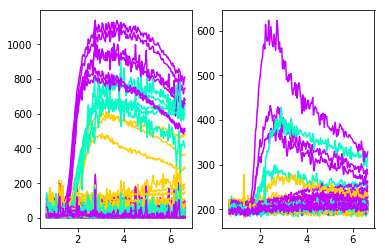

In [315]:
s=20; e=200
T=2 # min per frame
t=np.arange(s*T/60,e*T/60,T/60)
p_list=[]
t_exp = 150
f,ax = plt.subplots(1,2)
for i in range(292,391):
    p = d_g.comp_img_list[i]
    ax[1].plot(t,data[i,s:e]-back[i,s:e],c=cm.hsv(1.0/36*d_g.comp_img_list[i]));
    ax[0].plot(t,np.abs(data[i,s:e]-data[i-1,s:e]),c=cm.hsv(1.0/36*d_g.comp_img_list[i]));
    if p not in p_list: p_list.append(p)
    if ((data[i,t_exp]-back[i,t_exp])>250): print(i)
print (p_list)

In [ ]:
s=20; e=200
T=2 # min per frame
t=np.arange(s*T/60,e*T/60,T/60)
p_list=[]
t_exp = 100
for i in range(291,390):
    p = d_g.comp_img_list[i]
    #plt.plot(t,data[i,s:e]-back[i,s:e],c=cm.hsv(1.0/36*d_g.comp_img_list[i]));
    plt.plot(t,data[i,s:e]-data[i-1,s:e],c=cm.hsv(1.0/36*d_g.comp_img_list[i]));
    if p not in p_list: p_list.append(p)
    if ((data[i,t_exp]-back[i,t_exp])>180): print(i)
print (p_list)

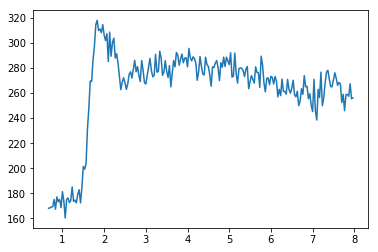

In [303]:
i=400
plt.plot(t,data[i,s:e]-back[i,s:e]);

In [ ]:
d_g = DataGrabber(
    preview_path = base_path + 'bf_2X2_50ms_ndf1_1\\',
    data_path = base_path + 'green_2X2_500ms_ndf0_1\\',
    out_path = base_path + 'auto_grab\\',
    design_csv_path = 'C:\\Users\\USER\\Documents\\GitHub\\2d compartments locations\\rev5\\2d_rev5_all_cross_talk_mirror.csv', #_cross_talk_mirror.csv
    stage_deg=stage_deg,
    markers=markers,
    flipy = True,
    flipx = False
)

print(d_g.comp_loc_autocad[5])
print(d_g.comp_loc_autocad[690])
print(d_g.design_markers)

# just checks

In [ ]:
# test
base_path = 'E:\\Data\\Josh_and_Omer\\20181104\\'
%matplotlib inline
stage_deg = 0 #-1.28
markers= Markers(
    m1_img_num= 0,
    m1_col= 298,
    m1_row= 342,
    m1_comp_num=0,#4,
    
    m2_img_num= 13,
    m2_col= 1069,
    m2_row= 784,
    m2_comp_num= 369# 364
)

d_g = DataGrabber(
    preview_path = base_path + 'datagrabber_rotated_cw\\',
    data_path = base_path + 'datagrabber_rotated_ccw\\',
    out_path = base_path + 'auto_grab_cw\\',
    design_csv_path = 'C:\\Users\\USER\\Documents\\GitHub\\2d compartments locations\\rev4.3\\2d_rev4_3_DNA_top_interlaced.csv', #_cross_talk_mirror.csv
    stage_deg=stage_deg,
    markers=markers,
    flipy = False,
    flipx = False
)


d_g.set_design_markers(markers)
#markers= Markers(0,704,1075,-1,484,400) # minus rotation
#markers= Markers(0,650,1085,-1,550,400)

d_g.compute_alignment()
d_g.show_comp_per_img()
d_g.show_alignment()

In [ ]:
# test
base_path = 'E:\\Data\\Josh_and_Omer\\20181104\\'
%matplotlib inline
stage_deg = 0 #-1.28
markers= Markers(
    m1_img_num= 0,
    m1_col= 338,
    m1_row= 212,
    m1_comp_num=4,
    
    m2_img_num= 13,
    m2_col= 1022,
    m2_row= 920,
    m2_comp_num= 364
)

d_g = DataGrabber(
    preview_path = base_path + 'datagrabber_rotated_ccw\\',
    data_path = base_path + 'datagrabber_rotated_ccw\\',
    out_path = base_path + 'auto_grab_ccw\\',
    design_csv_path = 'C:\\Users\\USER\\Documents\\GitHub\\2d compartments locations\\rev4.3\\2d_rev4_3_DNA_top_interlaced.csv', #_cross_talk_mirror.csv
    stage_deg=stage_deg,
    markers=markers,
    flipy = True,
    flipx = False
)


d_g.set_design_markers(markers)
#markers= Markers(0,704,1075,-1,484,400) # minus rotation
#markers= Markers(0,650,1085,-1,550,400)

d_g.compute_alignment()
d_g.show_comp_per_img()
d_g.show_alignment()